# Different Peformanve Evaluation Metrices

In [1]:
# regular import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# plt.style.use('bmh')
plt.rcParams['font.size'] = 11

### Data Loading and Train Test Split

In [3]:
# Loading the brest cancer data
data_uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
df = pd.read_csv(data_uri, header=None)

In [4]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
# Seperating the featu
features = df.loc[:, 2:].values
targets = df.loc[:, 1].values

In [7]:
le = LabelEncoder()
targets = le.fit_transform(targets)
le.classes_

array(['B', 'M'], dtype=object)

In [8]:
le.transform(["M", "B"])

array([1, 0])

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Train Test split
feat_train, feat_test, tar_train, tar_test = train_test_split(
    features, 
    targets, 
    test_size=0.2, 
    stratify=targets, 
    random_state=1
)

### Building Pipeline

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import cross_val_score

In [12]:
pipe_svc = make_pipeline(
    StandardScaler(), 
    SVC(random_state=1)
)

#### A. Reading Confusion Matrics

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
pipe_svc.fit(feat_train, tar_train)
tar_pred = pipe_svc.predict(feat_test)
confmat = confusion_matrix(y_true=tar_test, y_pred=tar_pred)
print(confmat)

[[71  1]
 [ 2 40]]


### Optimising the Precisoin and Re-call

Both the prediction error (ERR) and accuracy (ACC) provide general informationabout how many examples are misclassified.

`ERR = (FP + FN)/(FP + FN + TP + TN)`

`ACC = 1 - ERR = (TP + TN)/(FP + FN + TP + TN)`

The true positive rate: `TPR = TP/P = TP/(TP + FN)`

The false positive rate: `FPR = FP/N = FP/(FP + TN)`

The Precission: `PRE = TP/(TP + FP)`

The Recall: `REC = TPR`

The F1 score: `F1 = 2*(PRE * REC)/ (PRE + REC)`

In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

In [18]:
print("Pression {:.3f}".format(precision_score(y_true=tar_test, y_pred=tar_pred)))
print("Recall {:.3f}".format(recall_score(y_true=tar_test, y_pred=tar_pred)))
print("F1 Score {:.3f}".format(f1_score(y_true=tar_test, y_pred=tar_pred)))

Pression 0.976
Recall 0.952
F1 Score 0.964


_Remember that the positive class in scikit-learn is the class that is labeled as class 1. If we want to specify a different positive label, we can construct our own scorer via the make_scorer function, which we can then directly provide as an argument to the scoring parameter in GridSearchCV (in this example, using the f1_score as a metric):_

In [19]:
from sklearn.metrics import make_scorer, f1_score

In [22]:
c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [
    {"svc__C": c_gamma_range, 'svc__kernel': ["linear"]},
    {"svc__C": c_gamma_range, 'svc__kernel': ["rbf"]}
]
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)
gs = gs.fit(feat_train, tar_train)

print(gs.best_score_)
print(gs.best_params_)

0.9895564113719086
{'svc__C': 10.0, 'svc__kernel': 'rbf'}


## Plotting A Recever Operating Chr. Curve

In [23]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [28]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [33]:
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(
        penalty='l2',
        random_state=1,
        solver='lbfgs',
        C=100.0
    )
)

In [30]:
feat_train2 = feat_train[:, [4, 14]]

In [31]:
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(feat_train, tar_train))

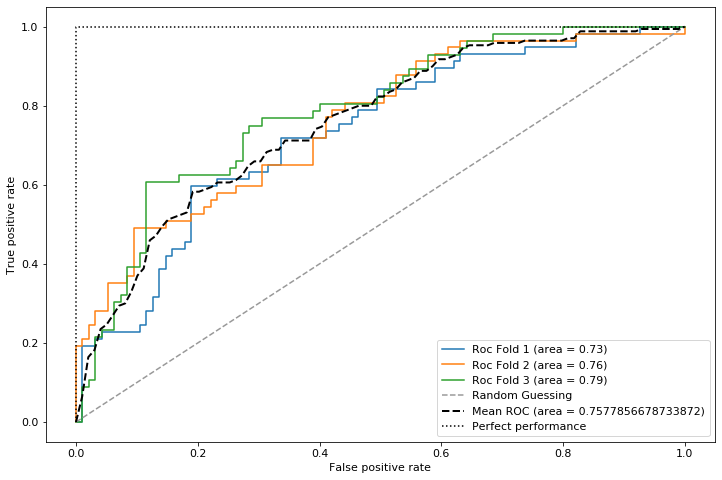

In [43]:
fig = plt.figure(figsize=(12, 8))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(
        feat_train2[train],
        tar_train[train]
    ).predict_proba(feat_train2[test])
    fpr, tpr, threshholds = roc_curve(tar_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = "Roc Fold {} (area = {:0.2f})".format(i + 1, roc_auc))


plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    color = (0.6, 0.6, 0.6),
    label="Random Guessing"
)

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = {})'.format(mean_auc), lw=2)


plt.plot(
    [0, 0, 1],
    [0, 1, 1],
    linestyle=':',
    color='black',
    label='Perfect performance'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()    

# References
[1] Python Machine Learning by Sebastian R.